In [71]:
import pandas as pd
import numpy as np
import os
import warnings
from pandas.core.common import SettingWithCopyWarning

In [73]:
def load(file_path):
    data = pd.read_csv(file_path, index_col=0)
    return data

warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*slice*")
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

## Cleaning TCGA expression data

link: https://xenabrowser.net/datapages/?dataset=TCGA.BRCA.sampleMap%2FHiSeqV2_percentile&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

1. Upload expression data and clinical data
2. TCGA samples with no radiation
3. Subset expression data to samples which have had no radiation
4. Remove low/zero variance genes
5. Remove genes with many null counts
6. Remove highly correlated genes
7. Save data

#### 1. Upload expression data and clinical data

In [74]:
perc_df = load('EX_TCGA.BRCA.sampleMap_HiSeqV2_percentile.csv')
perc_df_t = perc_df.T

In [75]:
clinical_df = load('TCGA.BRCA_CLINICAL.csv')

#### 2. TCGA samples with no radiation

In [76]:
clinical_df.columns = clinical_df.iloc[0]
clinical_df = clinical_df.drop('sampleID')

subset_df = clinical_df[['radiation_therapy']]

mask = ~subset_df['radiation_therapy'].isna()

df_cleaned = subset_df[mask]

TCGA_clinical_notr = df_cleaned[df_cleaned['radiation_therapy'].str.contains('NO')]

#### 3. Subset expression data to samples which have had no radiation

In [77]:
TCGA_exp_notr = perc_df_t.loc[perc_df_t.index.isin(TCGA_clinical_notr.index)]
TCGA_exp_notr = TCGA_exp_notr.sort_index(axis=1)

In [78]:
#check no of genes with all NA
num_genes_with_all_na = TCGA_exp_notr.isna().all(axis=0).sum()
print(f"Number of genes with all NA values: {num_genes_with_all_na}")

Number of genes with all NA values: 29


In [79]:
#drop these all NA genes
TCGA_exp_notr.drop(columns=TCGA_exp_notr.columns[TCGA_exp_notr.isna().all(axis=0)], inplace=True)

In [80]:
# Check for remaining missing values using .isnull() (same as .isna())
missing_values = TCGA_exp_notr.isnull().any()

# Print columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values == True])

Columns with missing values:
Series([], dtype: bool)


#### 4. Remove samples with many null counts

In [81]:
# Set the threshold for the maximum allowable percentage of null counts
max_null_percentage_threshold = 50  # Adjust as needed

# Calculate the percentage of null values (missing values) in each sample
sample_null_percentages = (TCGA_exp_notr.isna().sum(axis=1) / len(TCGA_exp_notr.columns)) * 100

# Filter out samples with high null percentages
tcga_data_filtered = TCGA_exp_notr[sample_null_percentages <= max_null_percentage_threshold]

# Display the number of removed samples
removed_samples_count = len(TCGA_exp_notr) - len(TCGA_exp_notr)
print(f"Removed {removed_samples_count} samples with high null counts.")

Removed 0 samples with high null counts.


#### 5. Remove genes with many null counts

In [82]:
# Calculate the percentage of 0.0 values in each gene (column)
percentage_zero = (tcga_data_filtered == 0.0).mean(axis=0)

# Filter out genes (columns) with more than 50% 0.0 values
threshold = 0.5
filtered_tcga = tcga_data_filtered.loc[:, percentage_zero <= threshold]

# Display the number of removed genes
removed_genes_cnt = len(tcga_data_filtered.columns) - len(filtered_tcga.columns)
print(f"Removed {removed_genes_cnt} genes with many null counts.")

Removed 2866 genes with many null counts.


#### 6. Percentile Ranking
Percentile normalisation should not contain 0.0 and 100.0 but for some reason, TCGA data didn't

In [83]:
# Apply percentile ranking
percentiles = filtered_tcga.rank(axis=1, pct=True) * 100

# Update the normalized rows back into the original dataframe
filtered_tcga.update(percentiles)

#### 7. Remove low/zero variance genes

In [84]:
# Set the threshold for the minimum acceptable variance
min_variance_threshold = 0.03

# Calculate the variance for each gene
gene_variances = filtered_tcga.var(axis=0)

# Filter out genes with low variance
tcga_d = filtered_tcga.loc[:, gene_variances >= min_variance_threshold]


tcga_cp_ola = tcga_d.copy()
tcga_cp_tala = tcga_d.copy()

# Display the number of removed genes
removed_genes_count = len(filtered_tcga.columns) - len(tcga_d.columns)
print(f"Removed {removed_genes_count} genes with low variance.")

Removed 9 genes with low variance.


#### 8. Match features to cleaned cell line expression

In [85]:
os.chdir('/Users/amyhayward/Documents/BIOINFORMATICS MSC/Project/FINAL_FILES')
cl_df = load('X_TRAIN_AH_OLA.csv')

In [86]:
matched_cols = cl_df.columns.intersection(tcga_d.columns)
match_tcga = tcga_d[matched_cols]
match_cl = cl_df[matched_cols]

In [87]:
X_test_exp = load("X_TEST_AH_OLA.csv")

In [88]:
matched_test = X_test_exp.columns.intersection(match_cl.columns)
match_test = X_test_exp[matched_test]

#### 9. Save data

In [89]:
cl_file = "X_TRAIN_MATCH_OLA.csv"
match_cl.to_csv(cl_file, index=True)

tcga_file = "TCGA_MATCH_OLA.csv"
match_tcga.to_csv(tcga_file, index=True)

file_test = "X_TEST_MATCH_OLA.csv"
match_test.to_csv(file_test, index=True)

#### 10. Venn Diagram

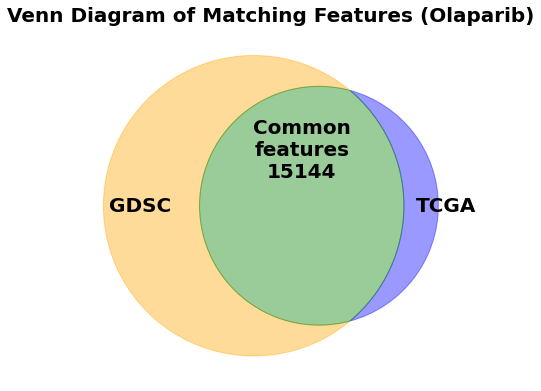

In [90]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

set1 = set(cl_df.columns)
set2 = set(tcga_d.columns) 


venn = venn2([set1, set2], ('', ''))

venn.get_label_by_id('10').set_x(-0.5)
venn.get_label_by_id('01').set_x(0.6)
venn.get_label_by_id('11').set_y(0.2)
# Add labels and titles
venn.get_label_by_id('10').set_text('GDSC')
venn.get_label_by_id('10').set_weight('bold')
venn.get_label_by_id('10').set_fontsize(20)
venn.get_label_by_id('01').set_text('TCGA')
venn.get_label_by_id('01').set_weight('bold')
venn.get_label_by_id('01').set_fontsize(20)
venn.get_label_by_id('11').set_text('Common\nfeatures\n15144')
venn.get_label_by_id('11').set_weight('bold')
venn.get_label_by_id('11').set_fontsize(20)

venn.get_patch_by_id('10').set_color('orange')   # Features only in GDSC
venn.get_patch_by_id('01').set_color('blue')     # Features only in TCGA
venn.get_patch_by_id('11').set_color('green') 

plt.title("Venn Diagram of Matching Features (Olaparib)", fontweight ='bold', size=20)
plt.show()